S Mohamed Ahsan : 212223240089
✅ File loaded successfully
Initial rows (after skipping bad lines): 145460
Rows after cleaning: 142193
✅ Dataset transformed
✅ BBN built successfully


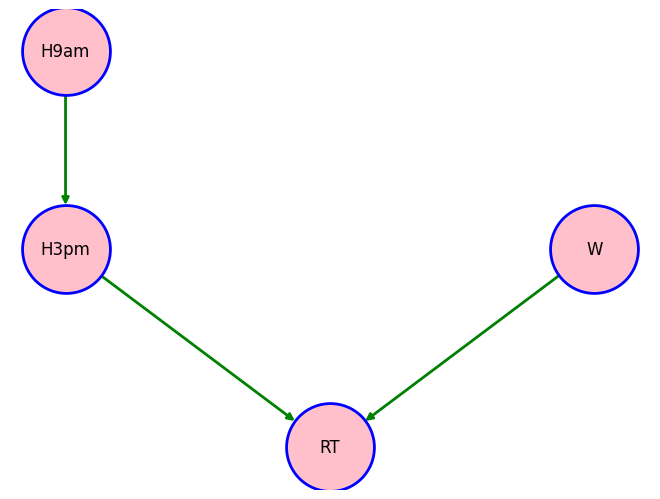


P(Humidity9am): [0.30658330578861126, 0.6934166942113887]

P(Humidity3pm | Humidity9am): [0.928269945405331, 0.071730054594669, 0.5576020040771205, 0.44239799592287954]

P(WindGustSpeed): [0.5865970898708094, 0.24039861315254618, 0.1730042969766444]

P(RainTomorrow | Humidity3pm, WindGustSpeed): [0.9231423408100351, 0.07685765918996491, 0.8907156673114119, 0.109284332688588, 0.7600840888188148, 0.23991591118118513, 0.6425022248590923, 0.35749777514090775, 0.4916834919719258, 0.5083165080280743, 0.3218170185540627, 0.6781829814459372]

🔎 Available nodes: ['H9am', 'H3pm', 'W', 'RT']

🔎 Query P(RainTomorrow | H3pm=>60)
{'No': 0.5507656919679813, 'Yes': 0.44923430803201875}

🔎 Available nodes: ['H9am', 'H3pm', 'W', 'RT']

🔎 Query P(RainTomorrow | W=>50)
{'No': 0.6160005493079643, 'Yes': 0.38399945069203556}


In [4]:
# ============================
# Bayesian Belief Network - WeatherAUS Example
# ============================

# S Mohamed Ahsan : 212223240089
print("S Mohamed Ahsan : 212223240089")

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.dag import Edge, EdgeType
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.graph.jointree import EvidenceBuilder

# -----------------------------
# 1. Load dataset safely
# -----------------------------
pd.options.display.max_columns = 50

try:
    raw_df = pd.read_csv(
        '/content/weatherAUS.csv',
        encoding='utf-8',
        engine='python',
        on_bad_lines='skip'
    )
    print("✅ File loaded successfully")
    print("Initial rows (after skipping bad lines):", len(raw_df))
except Exception as e:
    print("❌ Error loading CSV:", e)
    raw_df = None

if raw_df is None:
    raise SystemExit("❌ Cannot continue without dataset.")

# -----------------------------
# 2. Data cleaning
# -----------------------------
# Keep only rows with RainTomorrow
df = raw_df[raw_df['RainTomorrow'].notnull()]


if 'Date' in df.columns:
    df = df.drop(columns='Date')


df['Humidity9am'] = pd.to_numeric(df['Humidity9am'], errors='coerce')
df['Humidity3pm'] = pd.to_numeric(df['Humidity3pm'], errors='coerce')
df['WindGustSpeed'] = pd.to_numeric(df['WindGustSpeed'], errors='coerce')


numeric_columns = df.select_dtypes(include=['number']).columns
df.loc[:, numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

print("Rows after cleaning:", len(df))

# -----------------------------
# 3. Create categorical variables
# -----------------------------
df['WindGustSpeedCat'] = df['WindGustSpeed'].apply(
    lambda x: '0.<=40' if x <= 40 else '1.40-50' if 40 < x <= 50 else '2.>50'
)
df['Humidity9amCat'] = df['Humidity9am'].apply(
    lambda x: '1.>60' if x > 60 else '0.<=60'
)
df['Humidity3pmCat'] = df['Humidity3pm'].apply(
    lambda x: '1.>60' if x > 60 else '0.<=60'
)

print("✅ Dataset transformed")

# -----------------------------
# 4. Probability table helper
# -----------------------------
def probs(data, child, parent1=None, parent2=None):
    """
    Generate probability tables for BBN nodes.
    - If no parents: P(child)
    - If 1 parent:   P(child | parent1)
    - If 2 parents:  P(child | parent1, parent2)
    """
    if parent1 is None:
        prob = pd.crosstab(data[child], 'Empty', normalize='columns') \
                 .sort_index().to_numpy().reshape(-1).tolist()
    elif parent1 is not None and parent2 is None:
        prob = pd.crosstab(data[parent1], data[child], normalize='index') \
                 .sort_index().to_numpy().reshape(-1).tolist()
    else:
        prob = pd.crosstab([data[parent1], data[parent2]], data[child], normalize='index') \
                 .sort_index().to_numpy().reshape(-1).tolist()
    return prob

# -----------------------------
# 5. Define BBN nodes
# -----------------------------
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']),
               probs(df, child='Humidity9amCat'))

H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']),
               probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))

W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']),
            probs(df, child='WindGustSpeedCat'))

RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']),
             probs(df, child='RainTomorrow',
                   parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# -----------------------------
# 6. Build BBN graph
# -----------------------------
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

print("✅ BBN built successfully")

# -----------------------------
# 7. Visualize BBN
# -----------------------------
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}
options = {
    "font_size": 12,
    "node_size": 4000,
    "node_color": "pink",
    "edgecolors": "blue",
    "edge_color": "green",
    "linewidths": 2,
    "width": 2,
}
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)
plt.axis("off")
plt.show()

# -----------------------------
# 8. Show Probability Tables
# -----------------------------
print("\nP(Humidity9am):", probs(df, child='Humidity9amCat'))
print("\nP(Humidity3pm | Humidity9am):", probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
print("\nP(WindGustSpeed):", probs(df, child='WindGustSpeedCat'))
print("\nP(RainTomorrow | Humidity3pm, WindGustSpeed):",
      probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# -----------------------------
# 9. Query with Evidence (fixed version)
# -----------------------------
def query_with_evidence(var, value):
    """
    Query the network with a single piece of evidence.
    var   : variable name (e.g., 'H3pm', 'W')
    value : category (e.g., '>60', '>50')
    """
    jt = InferenceController.apply(bbn)

    available_nodes = [node.variable.name for node in bbn.get_nodes()]
    print("\n🔎 Available nodes:", available_nodes)

    node = next((n for n in bbn.get_nodes() if n.variable.name == var), None)
    if node is None:
        print(f"❌ Node '{var}' not found. Use one from: {available_nodes}")
        return

    ev = EvidenceBuilder() \
        .with_node(node) \
        .with_evidence(value, 1.0) \
        .build()
    jt.set_observation(ev)

    print(f"\n🔎 Query P(RainTomorrow | {var}={value})")
    for node_name, posteriors in jt.get_posteriors().items():
        if node_name == 'RT':
            print(posteriors)

# -----------------------------
# 10. Example Queries
# -----------------------------
query_with_evidence('H3pm', '>60')
query_with_evidence('W', '>50')


In [2]:
pip install networkx pandas matplotlib pybbn


  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40372 sha256=16fd7cc52bc0d6cecf955cd45eb90a532f30e26e9bae7f8fb732f68e69ce3697
  Stored in directory: /root/.cache/pip/wheels/97/20/85/52b65994184561eecc73318b47effb93e250a3dc3264db32c9
Successfully built pybbn
